# Final Soft Actor Critic: Pygame "Shooting Gallery"
### CSC 579 Reinforcement Learning, Spring 2023
#### Rylie Fleckenstein

## Assignment
Final Implementation: The code should be completed and bug free to the best of your knowledge.

Experimentation: Conduct experiments to evaluate the performance of the reinforcement learning algorithm on the problem. This may involve running simulations, collecting data, and analyzing results.

Comparison: If possible, compare the performance of your reinforcement learning algorithm with other state-of-the-art methods for solving the same problem. This will require a critical evaluation of the strengths and weaknesses of different algorithms. You may not be able to find other sources to compare your methods with. If this is the case, show your due diligence in searching for such a comparison instead.

## Overview

For my reinforcement learning project I opted to train an agent to play a game I coded up in PyGame. You can play the game by running `python game.py` in the console for this directory. In doing so, you will see it's a simple "Shooting Gallery" type game where a set of different targets, some having different sizes and rewards, are displayed on the screen and the goal is to "shoot" each of the targets, with your mouse acting as the "crosshair", by clicking on them. When a target is clicked it is removed from the screen and when all targets have been clicked/"shot" you win the game.  


Now, if we break down the problem, the environment is the screen, the crosshair location, and the set of targets displayed on the screen. The action space is the continuous (x, y) location of crosshair, representing where it should be moved to in order to hit targets and receive rewards. You could also include in the action space a discrete binary variable indicating a "click" or "no click" but to keep things simpler I decided to assume each (x, y) prediction represents a "click" and hard coded that functionality into the game and training.  


My initial thoughts on how to go about training an agent for this game were to follow closely with what DeepMind suggests in their paper "Playing Atari with Deep Reinforcement Learning" https://arxiv.org/abs/1312.5602. I decided I wanted to encode the state space using a convolutional neural network and decided to utilize the same architectural layout outlined in the aforementioned paper. Once I had my initial plan outlined, I decided to research different continuous action space algorithms to determine which would be the best for my problem. The paper used Q-learning because their problem had a discrete action space so I was more on my own and came up with 3 different algorithms which might be the best choice for my problem. The three algorithms I narrowed my search down to were REINFORCE, Proximal Policy Optimization, and Soft Actor Critic. I ended up selecting Soft Actor Critic because it is an off policy learning algorithm (something more closely related to Q-learning), it is one of the more state of the art algorithms currently around, SAC is more sample efficient, SAC has the potential to parallelized, and I wanted something that had shown to be effective in more real world problems so that should I want to adapt the knowledge I gain on this project to my work it will be worth my time. 

So, I had my strategy and algorithm narrowed down so the next step was to start training some agents. To train agents efficiently, I didn’t want to utilize the Pygame functionality and be constrained by the game loop, so I coded up a NumPy simulation of the game and that is what I used for training the agents. The simulation code can be found in `simulation.py`.

Also, it is important to note, for this project I chose to train the agents using the same environment and same set of targets over each episode of training as well as for evaluation. This is not what should be done if you are looking to train an agent that can generalize beyond the training samples and if you want an agent that isn't overfitting. The reason I took this approach is because I was unsure if the overall approach, I was taking could even solve the task at hand. The simplest way to generate a proof of concept, and iterate until you find possible solutions, is to pick one sample and see if you can get some models to overfit and learn the simple problem first. If you can overfit, then you know the problem is solvable and you can go back and rework things for generalization. So, should I continue this project, I would take my final solution and instead of training on the same set of targets and the same environment for each episode, I would randomize the environment for training and have a set of evaluation environments which would represent my end goal problem space. In doing this, it would take longer for the agents to learn and generalize and require more tweaking of the different model hyperparameters but would eventually lead to more robust agents who could successfully handle more situations than what they have seen in training.



In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, Image

# CNN

to train call `python train.py cnn`

to make the agent play the game call `python agentplay.py cnn`

Here I am showcasing what I am calling the CNN solution. Just to reiterate, the CNN approach is where I am using a convolutional neural network to encode the state space into a single vector which is then sent through a couple densely connected layers before being output to either two nodes which predict the mean, standard deviation (Actor network) or a single node for the state value prediction (Critic networks). Below you can see what the environment looks like with the training set of targets.

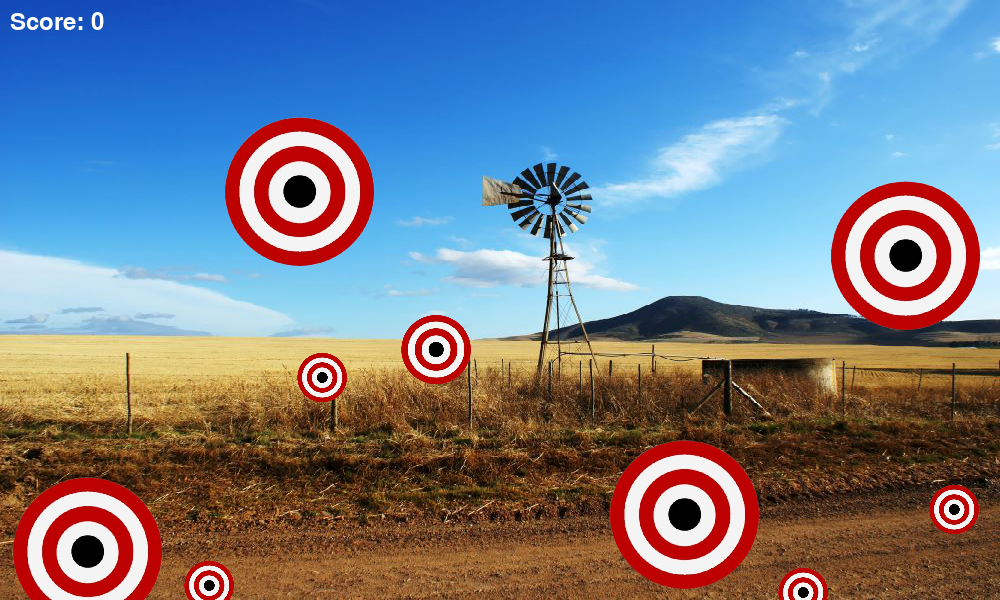

In [2]:
Image(filename="images/screenshot_1.png", width=500)

Below I highlight the training and evaluation scores for this method. I think in the long run this methodology would converge and learn to solve the problem, however, things were plateauing quite a bit and in order to start getting some meaningful results I felt I needed to change things up a bit. As context, the maximum value for this environment is ~500 so returns of 50 are pretty poor.

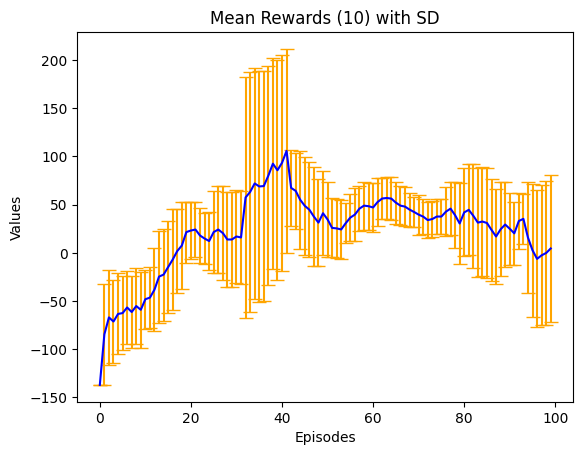

In [3]:
# training curves
cnndf = pd.read_csv('models/results_000006.csv')
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(range(len(cnndf)), cnndf['mean_10_reward'], yerr=cnndf['std_10_reward'], capsize=5, color='blue', ecolor='orange')
# Add axis labels and a title
ax.set_xlabel('Episodes')
ax.set_ylabel('Values')
ax.set_title('Mean Rewards (10) with SD')

# Display the plot
plt.show()

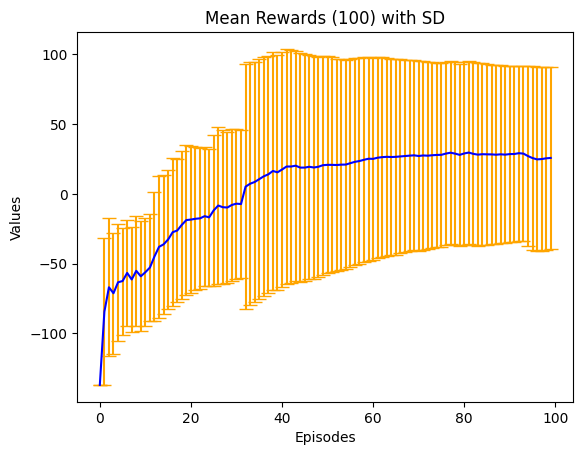

In [4]:
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(range(len(cnndf)), cnndf['mean_100_reward'], yerr=cnndf['std_100_reward'], capsize=5, color='blue', ecolor='orange')
# Add axis labels and a title
ax.set_xlabel('Episodes')
ax.set_ylabel('Values')
ax.set_title('Mean Rewards (100) with SD')

# Display the plot
plt.show()

To start formulating another plan of attack I started analyzing some of the intermediate model behaviors as well as the training result curves. Also, I took a look at the different action selection techniques, the one used for training and the one used for evaluation time. At evaluation time you are supposed to take the greedy action. To understand what the greedy action is, we need to remember that our Actor model actually returns a mean and standard deviation. Therefore, the mean is the greedy action. When we are training the agent, however, instead of taking the mean as the action we actually generate a distribution of values from the returned mean and standard deviation and then sample from that distribution. So, I looked at the model performance when I was sampling from the returned mean and standard deviation versus when I took the mean as the action and found that when I sampled from the returned mean and standard deviation the model would hit targets but not very well (see CNN figure 1). It almost seemed like the model generated a mean which represented the middle of the targets and then a standard deviation which represented the bounds of the targets and then found that if it sampled from within it, it would do generally well. To determine if my hypothesis was correct, I then set the action selection to greedy and looked at the model behavior and sure enough the model seemed to always return the same value which happened to be near the middle of the targets (see CNN figure 2).  

In [5]:
# cnn figure 1
HTML('<img src="cnngameplay1.gif" width="500">')

In [6]:
# cnn figure 2
HTML('<img src="cnngameplay2.gif" width="500">')

After thinking about it, I felt that encoding the entire image into one vector with a CNN might lose some "location information". This thought comes a bit from my experience working with semantic segmenation tasks. I know the whole purpose of the decoder portion of those architectures is to help maintain that location information which is generally lost in the encoder CNN. So, I thought about how I can maintain some level of location information while also reducing the dimensionality into a single vector. The goal here is to encode the environment in such a way that location information is kept somewhat intact while also making it so that we don't need to use convolutional neural networks but can maybe use densely connected neural networks. If we are going to be encoding the state space anyways, might as well do it in such a way that we can leverge networks which are computationally more efficient especially since we are training on CPUs and not GPUs.

# DNN

to train call `python train.py dnn`
to make the agent play the game call `python agentplay.py dnn`

Below you will see the proposed solution. The idea of encoding the state space can be broken down into two steps. The first step is the binary segmentation of the environment into either "targets" or "background". For simplicity, I generated ground truth masks and used that for training. However, this would be a great opportunity to invoke supervised learning methodologies to encode the state space before being used for training a reinforcement learning agent. You could and probably should, in a real-world situation, train a Unet (or some other encoder/decoder convolutional neural network) to learn to generate the binary masks with supervised learning. I did train a Unet to showcase the possibility, however, when I used it to encode the state space for model evaluation, the agent was not able to generalize as well. That is because the agent was trained using ground truth masks and it was pretty overfit to the training situation so that is to be expected. In the future I would train the model on the Unet outputs instead of the ground truth masking to help mitigate some of this. Although, that could also inject some noise into the training so it might need more research before implementation.  

  
The next step after generating the binary mask is to generate a grid over the screen (I used a 4x4 pixel grid). After you have generated the grid, to generate the final vector, we take the sum of each block in the grid as the vector value and unravel the grid into 1 dimension. Since it is a binary mask, any block with > 0 sum indicates the presence of a target. This encoding reduces the dimensionality of the state space, maintains "location information", and allows us to leverage densely connected neural networks.  

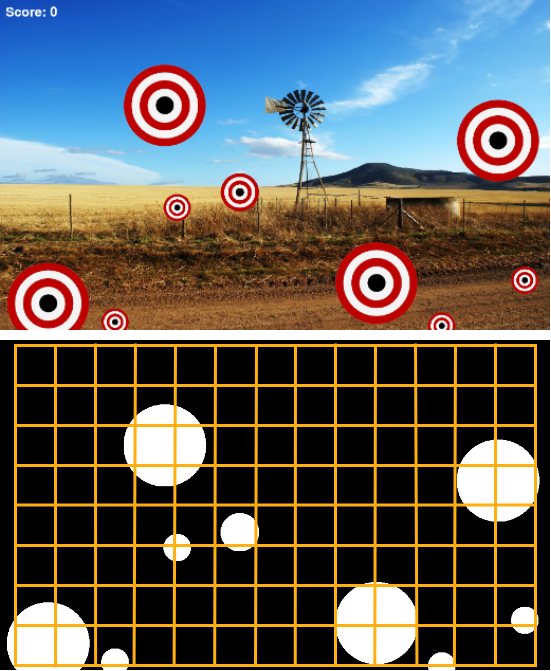

In [7]:
Image(filename="images/diagram.png", width=500)

Lets take a look at the training scores for the dnn approach. If we compare, this approach far outperforms the cnn approach as we start to get mean episode rewards up into the 200-300 range.

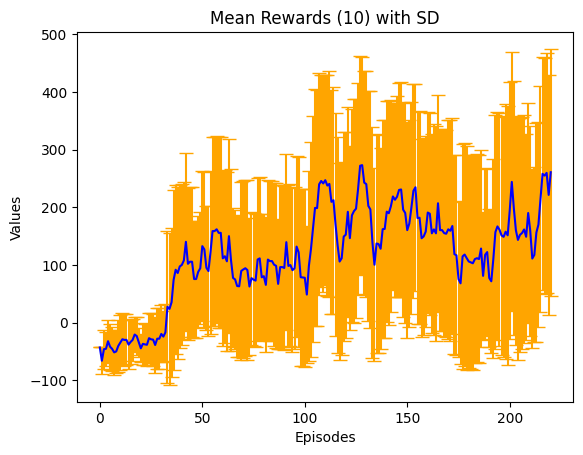

In [8]:
# training curves
dnndf = pd.read_csv('models/results_000008.csv')
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(range(len(dnndf)), dnndf['mean_10_reward'], yerr=dnndf['std_10_reward'], capsize=5, color='blue', ecolor='orange')
# Add axis labels and a title
ax.set_xlabel('Episodes')
ax.set_ylabel('Values')
ax.set_title('Mean Rewards (10) with SD')

# Display the plot
plt.show()

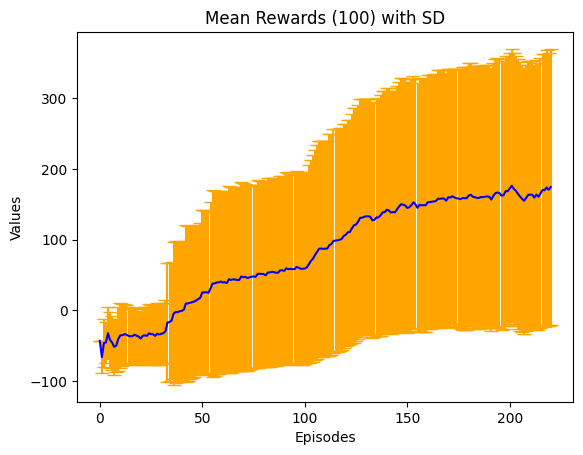

In [9]:
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(range(len(dnndf)), dnndf['mean_100_reward'], yerr=dnndf['std_100_reward'], capsize=5, color='blue', ecolor='orange')
# Add axis labels and a title
ax.set_xlabel('Episodes')
ax.set_ylabel('Values')
ax.set_title('Mean Rewards (100) with SD')

# Display the plot
plt.show()

# Evaluation

In [10]:
import copy
import torch
from tqdm import tqdm
from models import DActor
from train import dnn_init, dnn_process, dnn_iterate
from train import action_bounds, mparams, eval_targets, Experience

class Environment():
    def __init__(self, state_init, process_func, iteration_func):
        self.state_init = state_init
        self.process_func = process_func
        self.iteration_func = iteration_func
        
class Evaluator():
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env
        
    def interaction_step(self, state, targets):
        action = self.agent.select_greedy_action(torch.FloatTensor(self.env.process_func(state))).squeeze()
        reward, next_state, done = self.env.iteration_func(action, targets)
        return Experience(state.copy(), action.copy(), reward, next_state.copy(), done)
    
    def update_results(self, experience):
        return experience.next_state.copy(), experience.done
    
    def evaluate(self, n_episodes, max_steps):
        total_rewards = []
        for _ in tqdm(range(n_episodes)):
            rewards = []
            targets = copy.deepcopy(eval_targets)
            state, done = self.env.state_init(targets)
            print(state.dtype)
            rewards.append(0)
            for step in range(max_steps):
                experience = self.interaction_step(state, targets)
                state, done = self.update_results(experience)
                print(state.dtype)
                
                rewards[-1] += experience.reward
                if done or (step == (max_steps - 1)):
                    total_rewards.append(np.sum(np.array(rewards)))
                    break
        return total_rewards

In [11]:
dagent = DActor(action_bounds, mparams)
dagent.load_state_dict(torch.load('models/actor_000008_end.pt'))

<All keys matched successfully>

In [12]:
dagent

DActor(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (output_layer_mean): Linear(in_features=256, out_features=2, bias=True)
  (output_layer_log_std): Linear(in_features=256, out_features=2, bias=True)
)

In [13]:
from agentplay import *
def scale(action, dimensions):
    return (int(action.x*dimensions.get_width()), int(action.y*dimensions.get_height()))

def get_action(models):
    if models == "cnn":
        return actor.select_greedy_action(transforms.Resize((128, 128))(torch.FloatTensor(pygame.surfarray.array3d(screen).T / 255.))).squeeze()
    elif models == "dnn":
        create_masks(mask_surface, targets)
        return actor.select_greedy_action(
            torch.FloatTensor(
                cv2.resize(pygame.surfarray.array3d(mask_surface).T[0, :, :] / 255., (128, 128)).reshape(32, 32, 4, 4).sum(axis=(2,3)).ravel() / 16.)).squeeze()
# Initialize Pygame
total_rewards = []
for epsisode in range(100):
    rewards = []
    pygame.init()
    clock = pygame.time.Clock()
    screen = pygame.display.set_mode((screen_width, screen_height))
    mask_surface = pygame.Surface((screen_width, screen_height), flags=pygame.SRCALPHA)
    background_image = pygame.transform.scale(pygame.image.load('images/background.jpg').convert(), (screen_width, screen_height))
    crosshair_image = pygame.transform.scale(pygame.image.load('images/crosshair.png'), (int(.5*screen_width), int(.5*screen_width)))
    crosshair_rect = crosshair_image.get_rect()
    crosshair_rect.center = (screen_height // 2, screen_height // 2)
    pygame.mouse.set_visible(False)

    score = 0
    targets = generate_groups(screen, config)

    actor = DActor(action_bounds, mparams)
    actor.load_state_dict(torch.load('models/actor_000008_520.pt'))

    ticks = 0
    running = True
    done = False
    clicks = 0
    action = np.array([0.5, 0.5])

    while running:
        if not done:
            create_masks(mask_surface, targets)
            sstate = pygame.surfarray.array3d(mask_surface).T[0, :, :] / 255.
            action = get_action('dnn')
            clicks += 1
            for group in targets:
                score = check_hit(group, scale(Action(action[1], action[0]), screen), score)
        # check for user events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        screen.blit(background_image, (0, 0))
        for group in targets:
            group.draw(screen)

        crosshair_rect.center = scale(Action(action[1], action[0]), screen)
        screen.blit(crosshair_image, crosshair_rect)
        screen.blit(pygame.font.Font(None, 16).render("Score: " + str(score), True, (255, 255, 255)), (10, 10))
        screen.blit(pygame.font.Font(None, 16).render("Clicks: " + str(clicks), True, (255, 255, 255)), (100, 10))

        if get_count(targets) == 0:
            screen.blit(pygame.font.Font(None, 36).render("YOU WIN!", True, (255, 255, 255)), (.35*screen_height, .35*screen_width))
            total_rewards.append(score)
            done = True
            break

        pygame.display.update()
        clock.tick(60)
        ticks += 1

    # Quit Pygame
    pygame.quit()
# writer.close()

pygame 2.3.0 (SDL 2.24.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


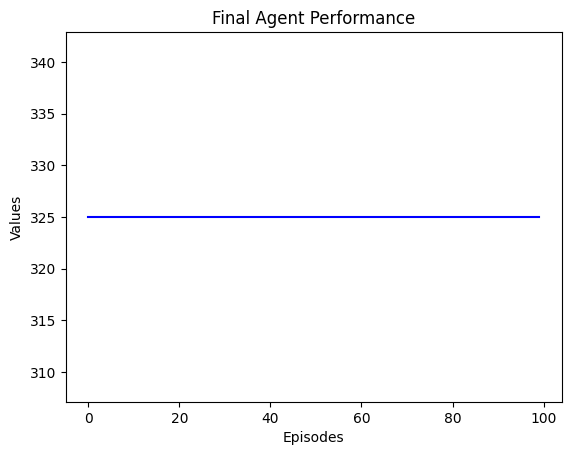

In [14]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(range(len(total_rewards)), total_rewards, color='blue')
# Add axis labels and a title
ax.set_xlabel('Episodes')
ax.set_ylabel('Values')
ax.set_title('Final Agent Performance')

# Display the plot
plt.show()

# Final Agent Playing the Game

In [15]:
HTML('<img src="dnngameplay.gif" width="500">')

# Comparison to Other Algorithms